In [11]:
import networkx as nx
import ndlib.models.ModelConfig as mc
import ndlib.models.epidemics as ep
import numpy as np
%matplotlib widget
import matplotlib.pyplot as plt
from ndlib.viz.mpl.DiffusionTrend import DiffusionTrend


In [12]:

# Create a graph (e.g., Erdős-Rényi graph)
# G = nx.erdos_renyi_graph(n=100, p=0.1)

G = nx.read_edgelist('./../datasets/BA_EXP/ba_edgelist_exp3_4000_10.edges', comments="%", nodetype=int)

In [13]:
G.number_of_nodes()

4000

In [14]:


# Get the mean degree (k) of the graph
degrees = [deg for _, deg in G.degree()]
mean_degree = np.mean(degrees)

# Calculate B_Threshold
B_Threshold = mean_degree / (mean_degree**2 - mean_degree)

# Range of B values
B_values = np.linspace(1 * B_Threshold, 1.9 * B_Threshold, 5)

# Number of iterations (M)
num_iterations = 100
num_nodes = G.number_of_nodes()

affected_scales = {}


In [15]:
B_values

array([0.11126565, 0.13630042, 0.16133519, 0.18636996, 0.21140473])

In [16]:
print(mean_degree)

# Second moment (mean of squared degrees)
mean_degree_squared = np.mean([deg**2 for deg in degrees])
print(mean_degree_squared)

# Epidemic threshold (B_Threshold)
B_Threshold = mean_degree / (mean_degree_squared - mean_degree)
# Range of B values
B_values = np.linspace(1 * B_Threshold, 2 * B_Threshold, 3)
print(B_values/B_Threshold)
B_values

9.9875
250.301
[1.  1.5 2. ]


array([0.0415603 , 0.06234044, 0.08312059])

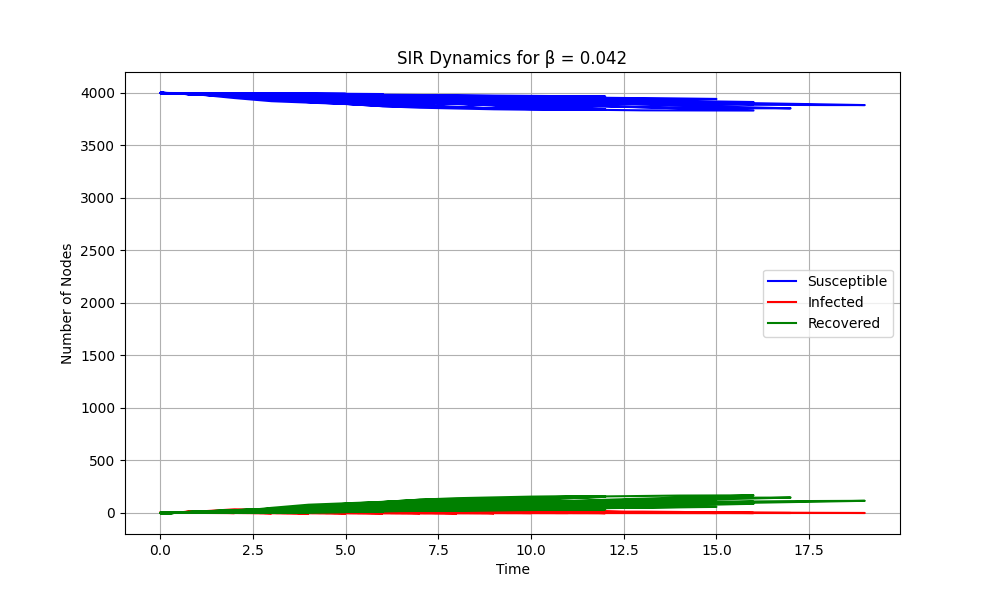

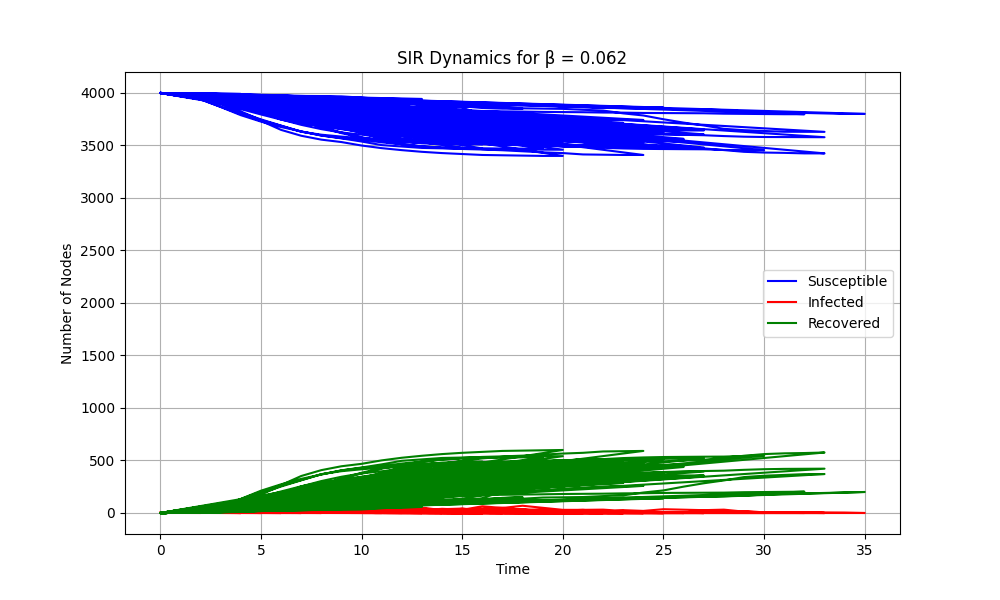

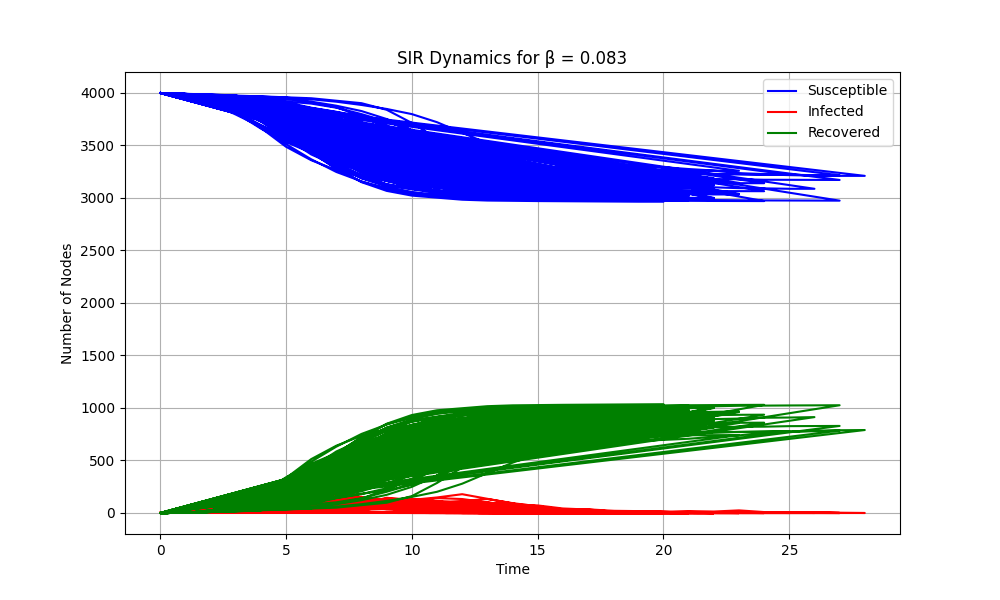

In [17]:
import matplotlib.pyplot as plt

# Initialize dictionaries to store trends for each B value
state_trends = {}

for B in B_values:
    trends = {'time': [], 'S': [], 'I': [], 'R': []}  # To store time and S/I/R counts

    for i in range(num_iterations):
        # Initialize the SIR model
        model = ep.SIRModel(G)
        
        # Configuration setup
        config = mc.Configuration()
        config.add_model_parameter('beta', B)  # Set infection rate to current B
        config.add_model_parameter('gamma', 1.0)  # Recovery probability = 1
        config.add_model_initial_configuration("Infected", {0: 1})  # Start with node 0 infected
        
        # Set the model configuration
        model.set_initial_status(config)
        
        iteration = None
        # Run the model until all nodes are either recovered or susceptible
        for step in range(200):  # Maximum 200 steps
            iteration = model.iteration()
            time_step = iteration['iteration']  # Current time step
            
            # Store trends
            trends['time'].append(time_step)
            trends['S'].append(iteration['node_count'][0])  # Susceptible count
            trends['I'].append(iteration['node_count'][1])  # Infected count
            trends['R'].append(iteration['node_count'][2])  # Recovered count
            
            # Check if all nodes are either recovered or susceptible (no infected nodes left)
            if iteration['node_count'][1] == 0:  # Index 1 corresponds to 'Infected'
                break  # Exit the loop if no infected nodes remain

    # Store the trends for the current B value
    state_trends[round(B, 3)] = trends

# Plotting the results for each B value
for B, trends in state_trends.items():
    plt.figure(figsize=(10, 6))
    plt.plot(trends['time'], trends['S'], label='Susceptible', color='blue')
    plt.plot(trends['time'], trends['I'], label='Infected', color='red')
    plt.plot(trends['time'], trends['R'], label='Recovered', color='green')
    plt.title(f'SIR Dynamics for β = {B}')
    plt.xlabel("Time")
    plt.ylabel("Number of Nodes")
    plt.legend()
    plt.grid()
    plt.show()
    plt.savefig(f"plot_for_B={round(B, 3)}.png", dpi=300)
    plt.close()   


In [10]:

infected_scales = {}
for B in B_values:
    recovered_sum = 0  # To store the sum of recovered nodes across all iterations
    infected_sum = 0
    # Store trends for plotting
    trends = []

    for i in range(num_iterations):
        # Initialize the SIR model
        model = ep.SIRModel(G)
        
        # Configuration setup
        config = mc.Configuration()
        config.add_model_parameter('beta', B)  # Set infection rate to current B
        config.add_model_parameter('gamma', 1.0)  # Recovery probability = 1
        config.add_model_initial_configuration("Infected", {0: 1})  # Start with node 0 infected
        
        # Set the model configuration
        model.set_initial_status(config)
        
        iteration = None
        # Run the model until all nodes are either recovered or susceptible
        for step in range(200):  # Maximum 200 steps
            iteration = model.iteration()
            trends.append(model.build_trends([iteration]))
            
            # Check if all nodes are either recovered or susceptible (no infected nodes left)
            if iteration['node_count'][1] == 0:  # Index 1 corresponds to 'Infected'
                break  # Exit the loop if no infected nodes remain
        
        # Get the final state after the infection spread
        final_state = iteration['node_count']
        if i%10==0:
            print(final_state)
        recovered_nodes = final_state[2]  # Index 2 represents 'Recovered' nodes
        recovered_sum += recovered_nodes
        infected_sum += final_state[1]

    
    # Calculate the affected scale for the current B
    affected_scale = recovered_sum / (num_iterations * num_nodes)
    affected_scales[round(B, 3)] = round(affected_scale, 3)
    infected_scales[round(B, 3)] = infected_sum 
    
    susceptible_values = []
    infected_values = []
    recovered_values = []
    
    for trend_list in trends:  # Iterating over the list of trend data
        for trend_dict in trend_list:  # Extracting the trend dictionaries
            if 'trends' in trend_dict:  # Ensure the dictionary contains 'trends'
                node_count = trend_dict['trends']['node_count']
                if len(node_count) >= 3:
                    susceptible_values.append(node_count[0][0])  # Susceptible
                    infected_values.append(node_count[1][0])  # Infected
                    recovered_values.append(node_count[2][0])  # Recovered

    plt.figure()
    plt.scatter(range(len(susceptible_values)), susceptible_values, label='Susceptible', marker='o')
    plt.scatter(range(len(recovered_values)), recovered_values, label='Recovered', marker='^')
    plt.scatter(range(len(infected_values)), infected_values, label='Infected', marker='x')
    plt.title(f"Diffusion Trend for B={round(B, 3)} - Iteration {i+1}")
    plt.xlabel("Time Step")
    plt.ylabel("Number of Nodes")
    plt.legend()
    plt.savefig(f"plot_for_B={round(B, 3)}.png", dpi=300)
    plt.close()


{0: 3984, 1: 0, 2: 16}
{0: 3981, 1: 0, 2: 19}
{0: 3862, 1: 0, 2: 138}
{0: 3960, 1: 0, 2: 40}
{0: 3990, 1: 0, 2: 10}
{0: 3986, 1: 0, 2: 14}
{0: 3895, 1: 0, 2: 105}
{0: 3946, 1: 0, 2: 54}
{0: 3990, 1: 0, 2: 10}
{0: 3991, 1: 0, 2: 9}
{0: 3548, 1: 0, 2: 452}
{0: 3981, 1: 0, 2: 19}
{0: 3542, 1: 0, 2: 458}
{0: 3577, 1: 0, 2: 423}
{0: 3972, 1: 0, 2: 28}
{0: 3947, 1: 0, 2: 53}
{0: 3597, 1: 0, 2: 403}
{0: 3505, 1: 0, 2: 495}
{0: 3434, 1: 0, 2: 566}
{0: 3558, 1: 0, 2: 442}
{0: 3135, 1: 0, 2: 865}
{0: 3067, 1: 0, 2: 933}
{0: 3110, 1: 0, 2: 890}
{0: 2967, 1: 0, 2: 1033}
{0: 3003, 1: 0, 2: 997}
{0: 3140, 1: 0, 2: 860}
{0: 3112, 1: 0, 2: 888}
{0: 3104, 1: 0, 2: 896}
{0: 3081, 1: 0, 2: 919}
{0: 3095, 1: 0, 2: 905}


In [ ]:

# Output the affected scales for each B
for B, scale in affected_scales.items():
    print(f"B = {B}: Affected scale = {scale}, infected_avg = {infected_scales[B]}")
print(affected_scales)
print(infected_scales)

B = 0.042: Affected scale = 0.01, infected_avg = 0
B = 0.052: Affected scale = 0.027, infected_avg = 0
B = 0.062: Affected scale = 0.08, infected_avg = 0
B = 0.073: Affected scale = 0.158, infected_avg = 0
B = 0.083: Affected scale = 0.224, infected_avg = 0
{np.float64(0.042): 0.01, np.float64(0.052): 0.027, np.float64(0.062): 0.08, np.float64(0.073): 0.158, np.float64(0.083): 0.224}
{np.float64(0.042): 0, np.float64(0.052): 0, np.float64(0.062): 0, np.float64(0.073): 0, np.float64(0.083): 0}
